In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import os
import glob
import numpy as np
import random
from einops import rearrange
import torch.nn.functional as F

In [2]:
class SementicSegmentationDrone(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, tile_size=512):
        self.images = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.masks = sorted(glob.glob(os.path.join(mask_dir, "*.png")))
        self.transform = transform
        self.tile_size = tile_size

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])

        image = image.resize((self.tile_size, self.tile_size))
        mask = mask.resize((self.tile_size, self.tile_size), Image.NEAREST)

        mask = np.array(mask)

        if image.size[0] > self.tile_size or image.size[1] > self.tile_size:
            image_tiles, mask_tiles = self.split_into_tiles(image, mask)
            idx_tile = random.randint(0, len(image_tiles) - 1)
            image, mask = image_tiles[idx_tile], mask_tiles[idx_tile]

        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask
    
    def split_into_tiles(self, image, mask):
        image_width, image_height = image.size
        image_tiles = []
        mask_tiles = []

        for i in range(0, image_width, self.tile_size):
            for j in range(0, image_height, self.tile_size):
                image_tile = image.crop((i, j, min(i+self.tile_size, image_width), min(j+self.tile_size, image_height)))
                mask_pil = Image.fromarray(mask) 
                mask_tile = mask_pil.crop((i, j, min(i+self.tile_size, image_width), min(j+self.tile_size, image_height)))
                image_tiles.append(image_tile)
                mask_tiles.append(np.array(mask_tile))

        return image_tiles, mask_tiles

In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=4, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        attn_out, _  = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ff(x))
        return x

In [4]:
class HybridDeepLabV3(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        self.model = deeplabv3_resnet101(pretrained=False, weights_backbone=None)
        state_dict = torch.load("/home/almon004/DroneSegmentationModel/deeplabv3_model/deeplabv3_resnet101.pth")
        state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}
        self.model.load_state_dict(state_dict, strict=False)

        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

        self.backbone = self.model.backbone
        self.classifier = self.model.classifier

        # Add transformer block after backbone feature map.
        self.transformer = TransformerBlock(dim=256, heads=4)

    def forward(self, x):
        features = self.model.backbone(x)['out']
        features = self.model.classifier[0](features)

        # Transformer expects flattened spatial dim.
        B, C, H, W = features.shape
        x_flat = rearrange(features, 'b c h w -> b (h w) c')
        x_flat = self.transformer(x_flat)
        x_trans = rearrange(x_flat, 'b (h w) c -> b c h w', h=H, w=W)

        # Upsample the result to match the target size (512x512)
        x_trans = F.interpolate(x_trans, size=(512, 512), mode='bilinear', align_corners=False)

        # Manually apply each classifier layer after the transformer
        x = self.model.classifier[1](x_trans)  # Apply the second classifier layer
        x = self.model.classifier[2](x)       # Apply the third classifier layer
        x = self.model.classifier[3](x)       # Apply the fourth classifier layer
        x = self.model.classifier[4](x)       # Apply the final classifier layer

        return {'out': x}

In [5]:
directory = {
    "train_images": "advanced_data/x_train",
    "train_masks": "advanced_data/y_train",
    "val_images": "advanced_data/x_valid",
    "val_masks": "advanced_data/y_valid",
    "test_images": "advanced_data/x_test",
    "test_masks": "advanced_data/y_test"
}

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = SementicSegmentationDrone(directory["train_images"], directory["train_masks"], transform=transform, tile_size=512)
valid_data = SementicSegmentationDrone(directory["val_images"], directory["val_masks"], transform=transform, tile_size=512)
test_data = SementicSegmentationDrone(directory["test_images"], directory["test_masks"], transform=transform, tile_size=512)

train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False)

In [6]:
# Initialize Model and Load Weights.
model = HybridDeepLabV3(num_classes=24)

# Get the current state_dict of the model
state_dict = model.state_dict()

# Create a new state_dict with corrected keys for the transformer
new_state_dict = {}

for key, value in state_dict.items():
    # Correct the transformer-related keys by removing 'model.' from the start
    if key.startswith('model.transformer'):
        new_key = key.replace('model.', '')  # Remove 'model.' from the key
    else:
        new_key = key  # Otherwise, keep the key as is
    
    new_state_dict[new_key] = value

# Load the updated state_dict into your model
missing, unexpected = model.load_state_dict(new_state_dict, strict=False)

# Move the model to the appropriate device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode.
model.eval()

/home/almon004/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/almon004/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


HybridDeepLabV3(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [7]:
import torch

# === Metric Functions ===
def calculate_miou(preds, masks, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # Ignore class
        else:
            ious.append(intersection / union)
    return torch.tensor(ious).nanmean().item()

def calculate_accuracy(preds, masks):
    return (preds == masks).float().mean().item()

def calculate_f1(preds, masks, num_classes):
    smooth = 1e-6
    f1s = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        tp = (pred_inds & target_inds).sum().item()
        fp = (pred_inds & (~target_inds)).sum().item()
        fn = ((~pred_inds) & target_inds).sum().item()
        if (tp + fp + fn) == 0:
            f1s.append(float('nan'))  # Ignore this class
        else:
            f1 = (2 * tp) / (2 * tp + fp + fn + smooth)
            f1s.append(f1)
    return torch.tensor(f1s).nanmean().item()

# === Setup ===
freeze_epochs = 5
total_epochs = 15
num_classes = 24  # <-- define your number of classes here
use_class_weights = False  # Set to True if needed

if use_class_weights:
    class_weights = torch.tensor([...]).to(device)  # Replace with actual weights
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_accuracies = []
valid_accuracies = []
train_mious = []
val_mious = []
train_f1s = []
val_f1s = []

# === Phase 1: Freeze Backbone ===
for param in model.backbone.parameters():
    param.requires_grad = False

print("Training with frozen backbone...")
for epoch in range(freeze_epochs):
    model.train()
    run_loss, run_acc, run_miou, run_f1 = 0.0, 0.0, 0.0, 0.0

    for images, masks in train_dataloader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
        
        preds = torch.argmax(outputs, dim=1)
        run_acc += calculate_accuracy(preds, masks)
        run_miou += calculate_miou(preds, masks, num_classes)
        run_f1 += calculate_f1(preds, masks, num_classes)

    train_accuracies.append(run_acc / len(train_dataloader))
    train_mious.append(run_miou / len(train_dataloader))
    train_f1s.append(run_f1 / len(train_dataloader))
    print(f'[Frozen] Epoch {epoch+1}, Loss: {run_loss / len(train_dataloader):.4f}, Acc: {train_accuracies[-1]:.4f}, mIoU: {train_mious[-1]:.4f}, F1: {train_f1s[-1]:.4f}')

    # === Validation ===
    model.eval()
    val_loss, total_iou, total_acc, total_f1, num_batches = 0.0, 0.0, 0.0, 0.0, 0
    with torch.no_grad():
        for images, masks in valid_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            total_iou += calculate_miou(preds, masks, num_classes)
            total_acc += calculate_accuracy(preds, masks)
            total_f1 += calculate_f1(preds, masks, num_classes)
            num_batches += 1

    valid_accuracies.append(total_acc / num_batches)
    val_mious.append(total_iou / num_batches)
    val_f1s.append(total_f1 / num_batches)
    print(f'[Frozen] Val Loss: {val_loss/num_batches:.4f}, mIoU: {val_mious[-1]:.4f}, Acc: {valid_accuracies[-1]:.4f}, F1: {val_f1s[-1]:.4f}')

# === Phase 2: Unfreeze and Continue ===
print("Unfreezing all weights...")
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam([
    {'params': model.backbone.parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
])

print("Training with unfrozen backbone...")
for epoch in range(freeze_epochs, total_epochs):
    model.train()
    run_loss, run_acc, run_miou, run_f1 = 0.0, 0.0, 0.0, 0.0

    for images, masks in train_dataloader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
        
        preds = torch.argmax(outputs, dim=1)
        run_acc += calculate_accuracy(preds, masks)
        run_miou += calculate_miou(preds, masks, num_classes)
        run_f1 += calculate_f1(preds, masks, num_classes)

    train_accuracies.append(run_acc / len(train_dataloader))
    train_mious.append(run_miou / len(train_dataloader))
    train_f1s.append(run_f1 / len(train_dataloader))
    print(f'[Unfrozen] Epoch {epoch+1}, Train Loss: {run_loss / len(train_dataloader):.4f}, Train Acc: {train_accuracies[-1]:.4f}, Train mIoU: {train_mious[-1]:.4f}, Train F1: {train_f1s[-1]:.4f}')

    # === Validation ===
    model.eval()
    val_loss, total_iou, total_acc, total_f1, num_batches = 0.0, 0.0, 0.0, 0.0, 0
    with torch.no_grad():
        for images, masks in valid_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            total_iou += calculate_miou(preds, masks, num_classes)
            total_acc += calculate_accuracy(preds, masks)
            total_f1 += calculate_f1(preds, masks, num_classes)
            num_batches += 1

    valid_accuracies.append(total_acc / num_batches)
    val_mious.append(total_iou / num_batches)
    val_f1s.append(total_f1 / num_batches)
    print(f'[Unfrozen] Val Loss: {val_loss/num_batches:.4f}, Val mIoU: {val_mious[-1]:.4f}, Val Acc: {valid_accuracies[-1]:.4f}, Val F1: {val_f1s[-1]:.4f}')


Training with frozen backbone...
[Frozen] Epoch 1, Loss: 2.5011, Acc: 0.4372, mIoU: 0.0780, F1: 0.1131
[Frozen] Val Loss: 1.6150, mIoU: 0.1083, Acc: 0.6077, F1: 0.1478
[Frozen] Epoch 2, Loss: 1.6991, Acc: 0.6263, mIoU: 0.1287, F1: 0.1734
[Frozen] Val Loss: 1.3426, mIoU: 0.1418, Acc: 0.6640, F1: 0.1878
[Frozen] Epoch 3, Loss: 1.4002, Acc: 0.6673, mIoU: 0.1493, F1: 0.1962
[Frozen] Val Loss: 1.1595, mIoU: 0.1503, Acc: 0.6898, F1: 0.1978
[Frozen] Epoch 4, Loss: 1.2134, Acc: 0.7011, mIoU: 0.1698, F1: 0.2203
[Frozen] Val Loss: 1.0818, mIoU: 0.1738, Acc: 0.7054, F1: 0.2279
[Frozen] Epoch 5, Loss: 1.0901, Acc: 0.7227, mIoU: 0.1912, F1: 0.2476
[Frozen] Val Loss: 0.9749, mIoU: 0.1943, Acc: 0.7272, F1: 0.2531
Unfreezing all weights...
Training with unfrozen backbone...
[Unfrozen] Epoch 6, Train Loss: 0.9904, Train Acc: 0.7382, Train mIoU: 0.2179, Train F1: 0.2820
[Unfrozen] Val Loss: 0.8910, Val mIoU: 0.2208, Val Acc: 0.7481, Val F1: 0.2826
[Unfrozen] Epoch 7, Train Loss: 0.8354, Train Acc: 0.785

In [12]:
# Metric storage
train_loss, val_loss, test_loss = [], [], []
train_acc, val_acc, test_acc = [], [], []
train_miou, val_miou, test_miou = [], [], []
train_f1, val_f1, test_f1 = [], [], []

def calculate_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float()
    return correct.sum() / correct.numel()

def calculate_miou(preds, labels, num_classes):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_mask = (preds == cls)
        label_mask = (labels == cls)
        intersection = (pred_mask & label_mask).sum().float()
        union = (pred_mask | label_mask).sum().float()
        if union == 0:
            ious.append(torch.tensor(1.0, device=preds.device))  # Avoid zero-division
        else:
            ious.append(intersection / union)
    return torch.mean(torch.stack(ious))

def calculate_f1_score(preds, labels, num_classes):
    preds = torch.argmax(preds, dim=1)
    f1_scores = []
    for cls in range(num_classes):
        pred_mask = (preds == cls)
        label_mask = (labels == cls)
        tp = (pred_mask & label_mask).sum().float()
        fp = (pred_mask & ~label_mask).sum().float()
        fn = (~pred_mask & label_mask).sum().float()

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)

        if precision + recall == 0:
            f1 = torch.tensor(1.0, device=preds.device)
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)
    return torch.mean(torch.stack(f1_scores))

def evaluate_model(dataloader, phase_name="Validation"):
    model.eval()
    total_loss, total_acc, total_miou, total_f1 = 0.0, 0.0, 0.0, 0.0
    num_classes = 24  # Modify as needed

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']

            loss = criterion(outputs, masks)
            acc = calculate_accuracy(outputs, masks)
            miou = calculate_miou(outputs, masks, num_classes)
            f1 = calculate_f1_score(outputs, masks, num_classes)

            total_loss += loss.item()
            total_acc += acc.item()
            total_miou += miou.item()
            total_f1 += f1.item()

    num_batches = len(dataloader)
    avg_loss = total_loss / num_batches
    avg_acc = total_acc / num_batches
    avg_miou = total_miou / num_batches
    avg_f1 = total_f1 / num_batches

    print(f"\n--- {phase_name} ---")
    print(f"Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}, mIoU: {avg_miou:.4f}, F1 Score: {avg_f1:.4f}")

    if phase_name == "Training":
        train_loss.append(avg_loss)
        train_acc.append(avg_acc)
        train_miou.append(avg_miou)
        train_f1.append(avg_f1)
    elif phase_name == "Validation":
        val_loss.append(avg_loss)
        val_acc.append(avg_acc)
        val_miou.append(avg_miou)
        val_f1.append(avg_f1)
    elif phase_name == "Test":
        test_loss.append(avg_loss)
        test_acc.append(avg_acc)
        test_miou.append(avg_miou)
        test_f1.append(avg_f1)

# Run evaluations
evaluate_model(train_dataloader, phase_name="Training")
evaluate_model(valid_dataloader, phase_name="Validation")
evaluate_model(test_dataloader, phase_name="Test")



--- Training ---
Loss: 0.3058, Accuracy: 0.9087, mIoU: 0.5926, F1 Score: 0.8353

--- Validation ---
Loss: 0.5771, Accuracy: 0.8363, mIoU: 0.4797, F1 Score: 0.7714

--- Test ---
Loss: 0.5298, Accuracy: 0.8406, mIoU: 0.4890, F1 Score: 0.7660


In [9]:
import pandas as pd

def load_class_color_map(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from column names
    id2name = {}
    id2color = {}

    for idx, row in df.iterrows():
        id2name[idx] = row['name']
        id2color[idx] = (row['r'], row['g'], row['b'])  # Accessing columns without spaces

    return id2name, id2color

class_names, class_colors = load_class_color_map("data/class_dict_seg.csv")

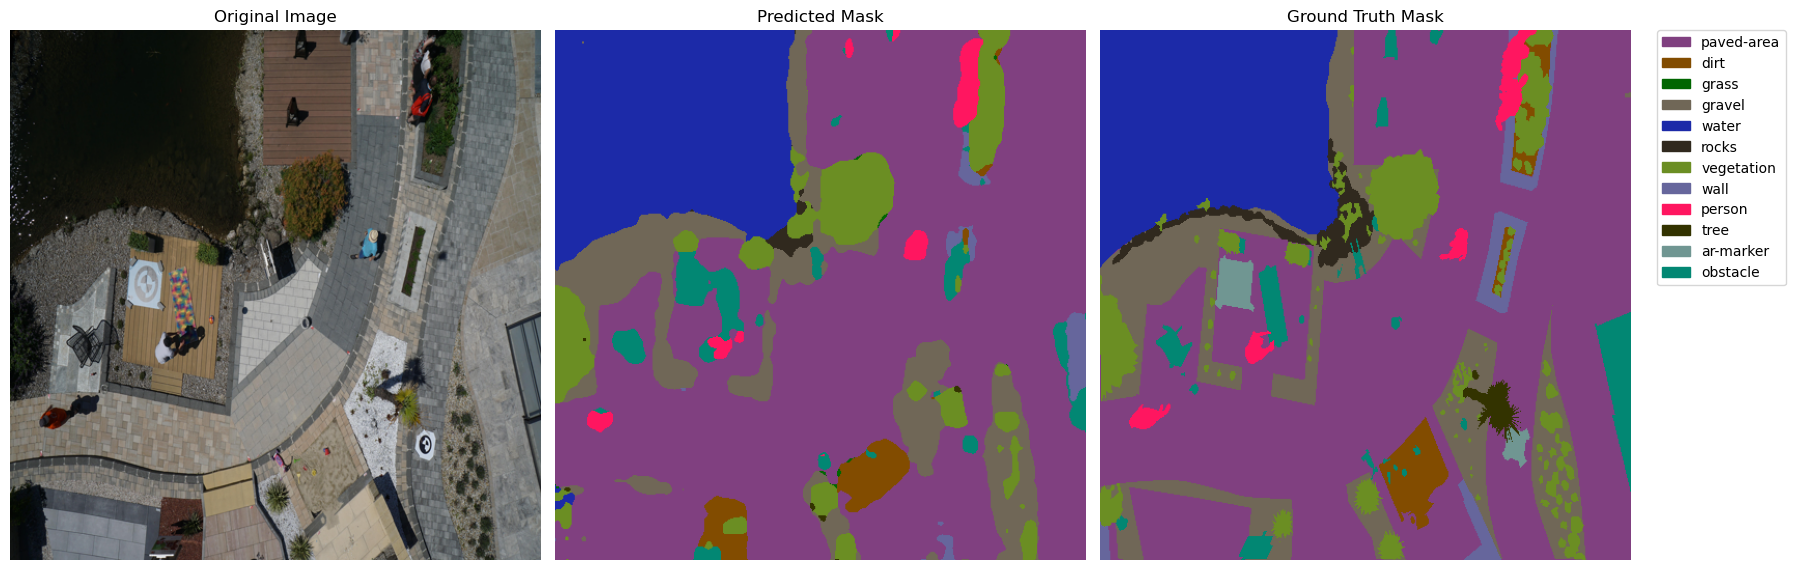

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def decode_segmentation_mask(mask, color_map):
    """Convert class-indexed mask to an RGB image."""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in color_map.items():
        color_mask[mask == class_id] = color
    return color_mask

def visualize_pred_vs_truth(image, pred_mask, true_mask, class_names, class_colors):
    """Visualize original image, predicted mask, and true mask side-by-side."""
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
        image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # De-normalize
        image = np.clip(image * 255, 0, 255).astype(np.uint8)

    pred_color_mask = decode_segmentation_mask(pred_mask.numpy(), class_colors)
    true_color_mask = decode_segmentation_mask(true_mask.numpy(), class_colors)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_color_mask)
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(true_color_mask)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Create legend
    unique_ids = np.unique(np.concatenate([pred_mask.numpy().flatten(), true_mask.numpy().flatten()]))
    patches = [mpatches.Patch(color=np.array(class_colors[cls]) / 255, label=class_names[cls])
               for cls in unique_ids if cls in class_names]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# Run on one test sample
model.eval()
with torch.no_grad():
    for images, masks in test_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']  # shape: (B, C, H, W)
        preds = torch.argmax(outputs, dim=1)  # shape: (B, H, W)

        # Visualize first sample in batch
        visualize_pred_vs_truth(images[0].cpu(), preds[0].cpu(), masks[0].cpu(), class_names, class_colors)
        break

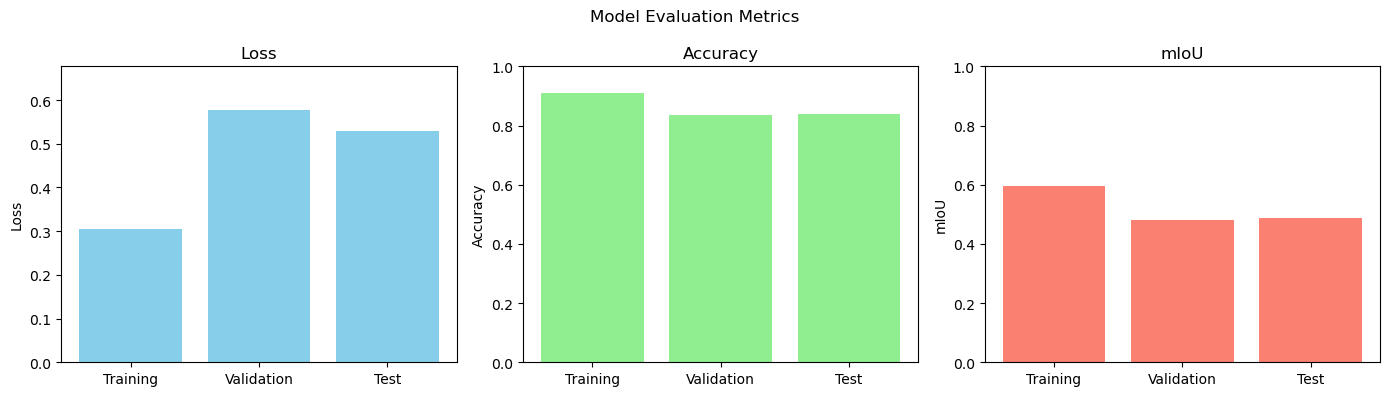

In [11]:
# === Visualization ===
phases = ['Training', 'Validation', 'Test']

# Loss
losses = [train_loss[-1], val_loss[-1], test_loss[-1]]

# Accuracy
accuracies = [train_acc[-1], val_acc[-1], test_acc[-1]]

# mIoU
mious = [train_miou[-1], val_miou[-1], test_miou[-1]]

# Plotting the metrics
plt.figure(figsize=(14, 4))

# Loss
plt.subplot(1, 3, 1)
plt.bar(phases, losses, color='skyblue')
plt.title("Loss")
plt.ylabel("Loss")
plt.ylim(0, max(losses) + 0.1)

# Accuracy
plt.subplot(1, 3, 2)
plt.bar(phases, accuracies, color='lightgreen')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# mIoU
plt.subplot(1, 3, 3)
plt.bar(phases, mious, color='salmon')
plt.title("mIoU")
plt.ylabel("mIoU")
plt.ylim(0, 1)

plt.suptitle("Model Evaluation Metrics")
plt.tight_layout()
plt.show()